## Porter Delivery Time Estimation

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Abstract:
    
In this article, we cover the construction of a model to predict the relationship between order information and delivery time using the Porter Delivery Time Estimation dataset. To accomplish this, we employed two approaches.
Firstly, we opted for a regression model to predict the continuous target variable (delivery time).
Secondly, we chose a classification model to predict the categorical target variable (fast, moderate, slightly slow, slow) after converting it.
In this article, we will cover the second approach, which involves handling the Porter Delivery Time Estimation dataset using a classification model.
To achieve this, we created a new target variable for delivery time ("How_Long") by utilizing "created_at" and "actual_delivery_time" and established the following criteria to convert this variable into categorical data.

1 to 30 minutes: Fast

30 to 60 minutes: Average.

60 to 90 minutes: Slightly Slow.

More than 90 minutes: Slow.

By categorically transforming the target variable in this manner, a classification model was constructed. This Model is expected to provide customers with intuitive delivery time information for new orders and contribute to efficiently managing the delivery process.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
df=pd.read_csv(r"C:\Projects Vinay\BIA-main\Vinay Padwal Data Science\dataset_Vinay.csv")

In [4]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

### Selection of Target Variable

Considering that delivery time isn't provided directly, and we have information about cooking completion and delivery completion times, we needed to create a new target variable. Since our goal is to predict delivery time, we subtracted the cooking completion time from the delivery completion time and represented this difference in minutes.

Then, we converted this variable into the categorical data with following criteria.

1 to 30 minutes: Fast
30 to 60 minutes: Average.
60 to 90 minutes: Slightly Slow.
More than 90 minutes: Slow.
This newly created variable reflects the time taken for delivery. This approach allows us to develop a predictive model for delivery time based on various factors.

In [6]:
# Convert to time format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate the difference between two date columns (converted to minutes)
df['How_Long'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [7]:
# Convert to Categorical Target variable

def map_how_long_category(value):
    if value <= 20:
        return 0
    elif value <= 40:
        return 1
    elif value <= 60:
        # Check the count of null values
        return 2
    else:
        return 3

df['How_Long'] = df['How_Long'].apply(map_how_long_category)
null_value_counts = df.isnull().sum()

In [8]:
# Drop unnecessary columns
df.drop(['market_id', 'created_at', 'actual_delivery_time', 'store_id'], axis=1, inplace=True)

In [9]:
# Check the count of null values
null_value_counts = df.isnull().sum()

In [10]:
# Get the indices of rows with missing values in the 'How_Long' column
How_Long_null = df[df["How_Long"].isna()].index

# Drop the rows with missing values based on the indices stored in How_Long_null
df.drop(index=How_Long_null, inplace=True)

# Display the updated shape of the DataFrame
df.shape

(197428, 11)

In [11]:
# Check the count of null values again after dropping rows with missing values
null_value_counts_after_drop = df.isnull().sum()

### Preprocessing of Continuous Variable

In [12]:
# List of columns containing continuous variables
cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 
        'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']

# Generate descriptive statistics for the selected continuous variables
continuous_stats = df[cols].describe()

In [13]:
#Skewness is a statistical measure that describes the symmetry of the data distribution:
df[cols].skew()

total_items                 21.413824
subtotal                     1.961501
num_distinct_items           1.591479
min_item_price               2.331280
max_item_price               2.201033
total_onshift_partners       0.860758
total_busy_partners          0.782463
total_outstanding_orders     1.195322
dtype: float64

In [16]:
#Kurtosis is a statistical measure that describes the distribution of data points
df[cols].kurtosis()

total_items                 2801.421341
subtotal                       5.998577
num_distinct_items             4.269621
min_item_price                14.602635
max_item_price                12.915451
total_onshift_partners        -0.035222
total_busy_partners           -0.190401
total_outstanding_orders       0.861244
dtype: float64

### Handling and Outlier Removal¶

We were able to consider the existence of outliers as we examined the mean, maximum, and minimum values of continuous variables. In fact, when we checked the skewness and kurtosis, we confirmed that they were not within the normal range. Therefore, we have decided to work on addressing these outliers.

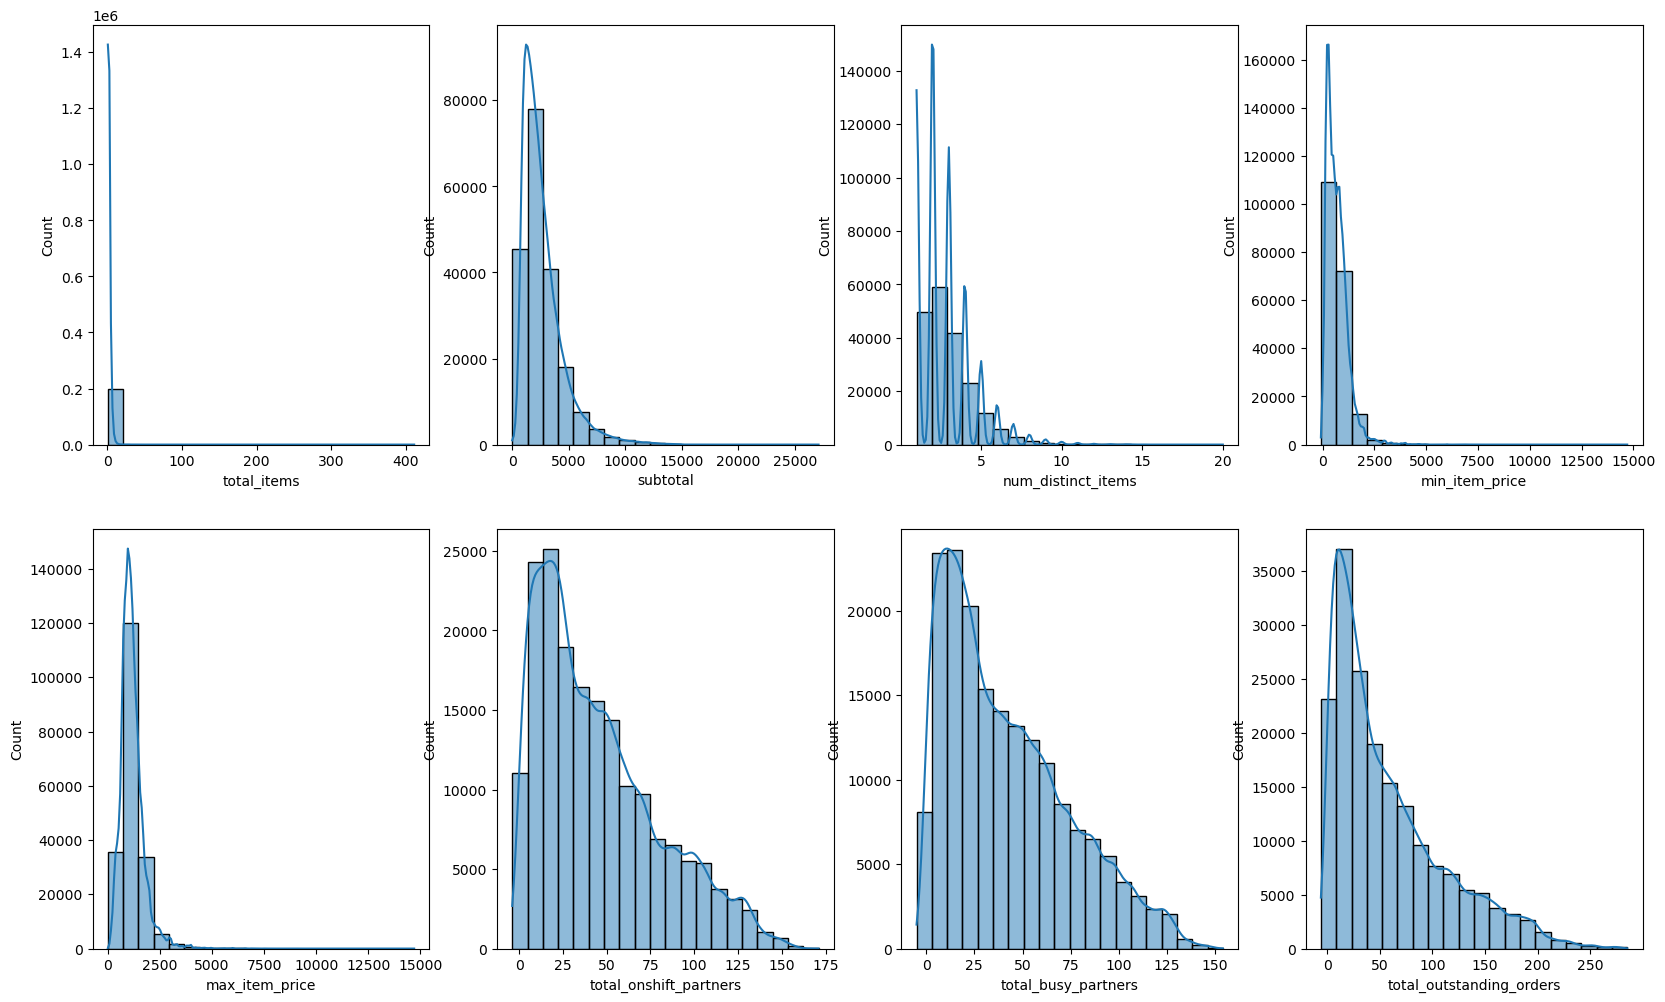

In [17]:
# Create a 2x4 grid of subplots with a specified figure size

fig, ((ax1, ax2, ax3, ax4), 
      (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 12))

sns.histplot(ax=ax1, x = 'total_items', data = df, kde=True, bins=20)
sns.histplot(ax=ax2, x = 'subtotal', data = df, kde=True, bins=20)
sns.histplot(ax=ax3, x = 'num_distinct_items', data = df, kde=True, bins=20)
sns.histplot(ax=ax4, x = 'min_item_price', data = df, kde=True, bins=20)
sns.histplot(ax=ax5, x = 'max_item_price', data = df, kde=True, bins=20)
sns.histplot(ax=ax6, x = 'total_onshift_partners', data = df, kde=True, bins=20)
sns.histplot(ax=ax7, x = 'total_busy_partners', data = df, kde=True, bins=20)
sns.histplot(ax=ax8, x = 'total_outstanding_orders', data = df, kde=True, bins=20)

# Display the plot
plt.show();

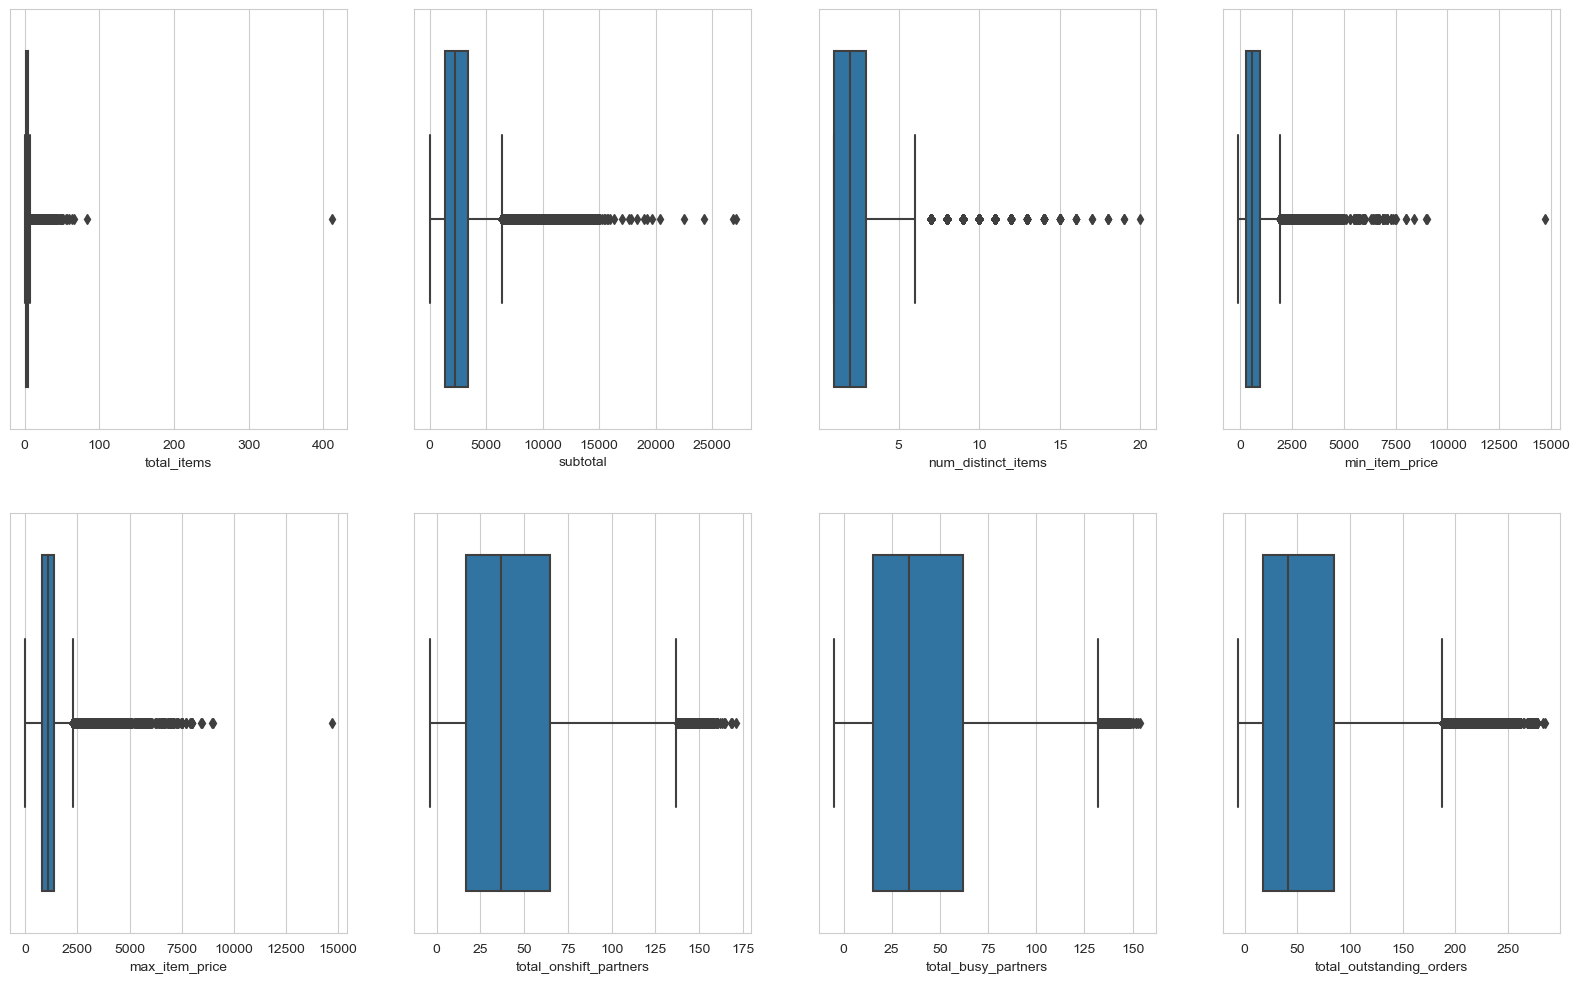

In [18]:
# Set the Seaborn style to 'whitegrid'
sns.set_style('whitegrid')

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), 
      (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x = 'total_items', data = df)
sns.boxplot(ax=ax2, x = 'subtotal', data = df)
sns.boxplot(ax=ax3, x = 'num_distinct_items', data = df)
sns.boxplot(ax=ax4, x = 'min_item_price', data = df)
sns.boxplot(ax=ax5, x = 'max_item_price', data = df)
sns.boxplot(ax=ax6, x = 'total_onshift_partners', data = df)
sns.boxplot(ax=ax7, x = 'total_busy_partners', data = df)
sns.boxplot(ax=ax8, x = 'total_outstanding_orders', data = df)

# Display the plot
plt.show()

In [19]:
# Calculate the interquartile range (IQR) for each variable
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

# Display the calculated IQR
print(IQR)

Lower = Q1-3.0*IQR
Upper = Q3+3.0*IQR

total_items                    2.0
subtotal                    1995.0
num_distinct_items             2.0
min_item_price               650.0
max_item_price               595.0
total_onshift_partners        48.0
total_busy_partners           47.0
total_outstanding_orders      68.0
dtype: float64


In [20]:
#Data Cleaning Outlier Removal and Range-based Filtering

c0 = (df['total_items'] >= Lower['total_items']) & (df['total_items'] <= Upper['total_items'])
c1 = (df['subtotal'] >= Lower['subtotal']) & (df['subtotal'] <= Upper['subtotal'])
c2 = (df['num_distinct_items'] >= Lower['num_distinct_items']) & (df['num_distinct_items'] <= Upper['num_distinct_items'])
c3 = (df['min_item_price'] >= Lower['min_item_price']) & (df['min_item_price'] <= Upper['min_item_price'])
c4 = (df['max_item_price'] >= Lower['max_item_price']) & (df['max_item_price'] <= Upper['max_item_price'])
c5 = (df['total_onshift_partners'] >= Lower['total_onshift_partners']) & (df['total_onshift_partners'] <= Upper['total_onshift_partners'])
c6 = (df['total_busy_partners'] >= Lower['total_busy_partners']) & (df['total_busy_partners'] <= Upper['total_busy_partners'])
c7 = (df['total_outstanding_orders'] >= Lower['total_outstanding_orders']) & (df['total_outstanding_orders'] <= Upper['total_outstanding_orders'])

# Filter the DataFrame based on the combined boolean conditions
df = df[c0 & c1 & c2 & c3 & c4 & c5 & c6 & c7]

# Display the updated shape of the DataFrame
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (174993, 11)


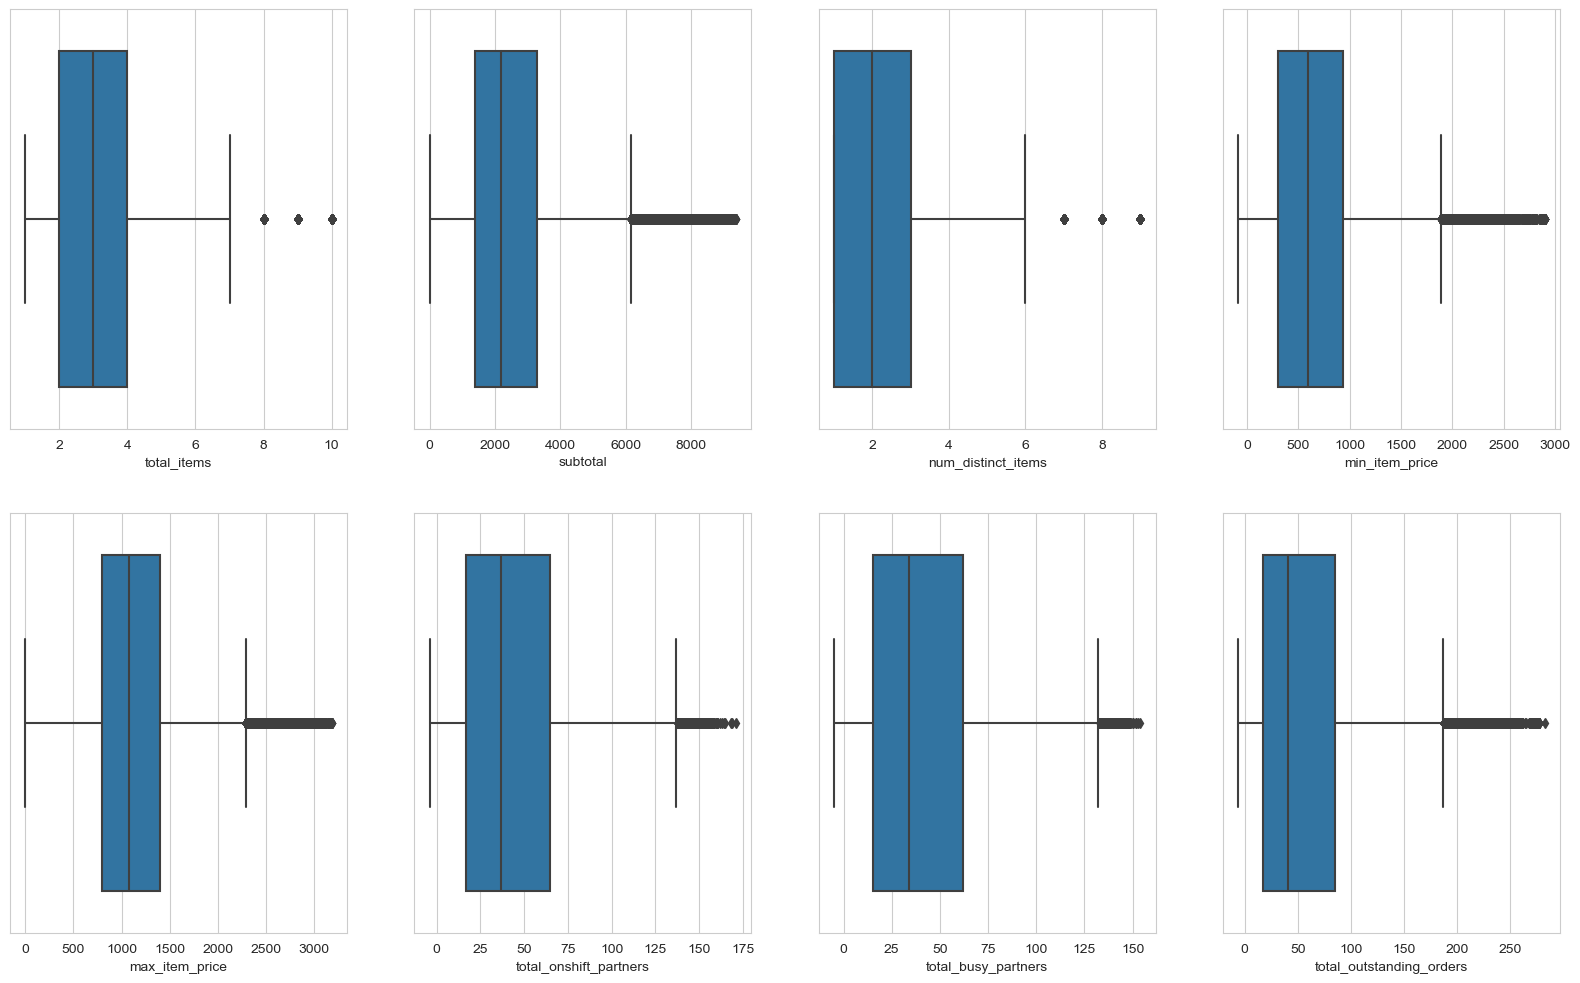

In [21]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), 
      (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x = 'total_items', data = df)
sns.boxplot(ax=ax2, x = 'subtotal', data = df)
sns.boxplot(ax=ax3, x = 'num_distinct_items', data = df)
sns.boxplot(ax=ax4, x = 'min_item_price', data = df)
sns.boxplot(ax=ax5, x = 'max_item_price', data = df)
sns.boxplot(ax=ax6, x = 'total_onshift_partners', data = df)
sns.boxplot(ax=ax7, x = 'total_busy_partners', data = df)
sns.boxplot(ax=ax8, x = 'total_outstanding_orders', data = df)

# Display the plot
plt.show()

In [22]:
# Select the columns containing numerical variables
numerical_df = df[cols]

# Calculate the median for each column
column_median = numerical_df.median()

# Fill missing values in the numerical columns with the corresponding median values
numerical_df.fillna(column_median, inplace=True)

# Update the original DataFrame with the filled numerical columns
df[cols] = numerical_df

C:\Users\HP\AppData\Local\Temp\ipykernel_11348\1206303782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df.fillna(column_median, inplace=True)


#### Checking Variables for Skewness and Kurtosis

In [23]:
df[cols].skew()

total_items                 1.230730
subtotal                    1.316405
num_distinct_items          1.093038
min_item_price              1.123812
max_item_price              0.889593
total_onshift_partners      0.861370
total_busy_partners         0.782314
total_outstanding_orders    1.194740
dtype: float64

In [24]:
df[cols].kurtosis()

total_items                 1.509496
subtotal                    1.881259
num_distinct_items          1.253974
min_item_price              1.660520
max_item_price              1.366761
total_onshift_partners     -0.035810
total_busy_partners        -0.192057
total_outstanding_orders    0.857650
dtype: float64

After removing outliers, we can observe that both the skewness and kurtosis have fallen within the normal range.

In [27]:
#Checking Correlations

# Calculate and round the correlation matrix between the interval variables
correlation_matrix = df[cols].corr().round(2)

# Display the correlation matrix
print(correlation_matrix)

                          total_items  subtotal  num_distinct_items  \
total_items                      1.00      0.67                0.89   
subtotal                         0.67      1.00                0.67   
num_distinct_items               0.89      0.67                1.00   
min_item_price                  -0.50      0.02               -0.49   
max_item_price                  -0.01      0.55                0.08   
total_onshift_partners           0.06      0.15                0.07   
total_busy_partners              0.05      0.14                0.07   
total_outstanding_orders         0.06      0.15                0.07   

                          min_item_price  max_item_price  \
total_items                        -0.50           -0.01   
subtotal                            0.02            0.55   
num_distinct_items                 -0.49            0.08   
min_item_price                      1.00            0.48   
max_item_price                      0.48            1.00   


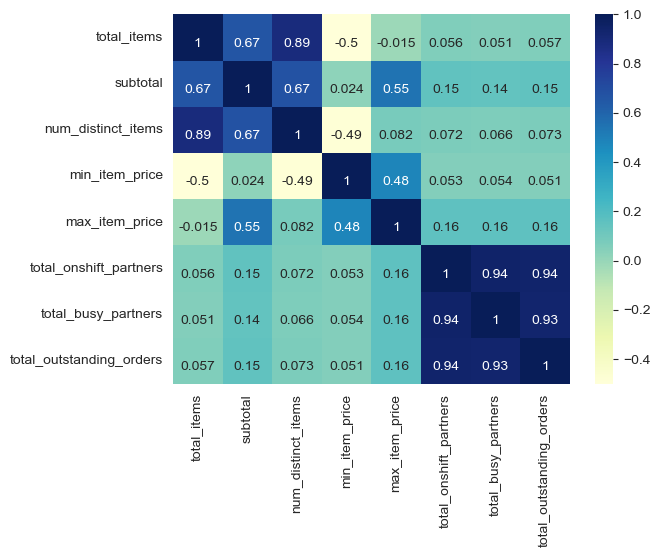

In [28]:
# Calculate the correlation matrix between the interval variables
corr = df[cols].corr()

# Define annotation keyword arguments for heatmap
annot_kws = {"ha": 'center', "va": 'top'}

# Create a heatmap with annotations
sns.heatmap(data=corr, annot=True, annot_kws=annot_kws, cmap="YlGnBu")

# Display the plot
plt.show()

total_onshift_partners, total_busy_partners and total_outstanding_orders have a high correlation.

Similarly, total_items, subtotal and num_distinct_items also have a high correlation

#### Preprocessing Categorical Variables¶

In [30]:
# Calculate the percentage of missing values for the specified columns
missing_percentage = df[['store_primary_category', 'order_protocol']].isnull().sum() / len(df[['store_primary_category', 'order_protocol', 'How_Long']])

# Display the calculated missing percentage
print(missing_percentage)

store_primary_category    0.023144
order_protocol            0.005092
dtype: float64


In [31]:
# List of columns to fill missing values
cols1 = ['store_primary_category', 'order_protocol']

# Fill missing values with the mode value for each column
for col in cols1:
    mode_value = df[col].mode().iloc[0]  # Calculate the mode value
    df[col].fillna(mode_value, inplace=True)  # Fill missing values with the mode value

In [32]:
df[['store_primary_category','order_protocol']].isnull().sum()

store_primary_category    0
order_protocol            0
dtype: int64

In [33]:
# List of categorical columns
cols1 = ['store_primary_category', 'order_protocol']

# Create a DataFrame containing only the selected categorical variables
df1 = df[cols1]

# Loop through each categorical column and print value counts with proportions
for col in df1.columns:
    print("")
    print("---- %s ---" % col)
    print(df[col].value_counts(dropna=False, normalize=True))


---- store_primary_category ---
store_primary_category
american             0.124131
pizza                0.089118
mexican              0.087506
burger               0.056408
sandwich             0.050985
                       ...   
african              0.000057
lebanese             0.000051
belgian              0.000011
chocolate            0.000006
alcohol-plus-food    0.000006
Name: proportion, Length: 73, dtype: float64

---- order_protocol ---
order_protocol
1.0    0.284491
3.0    0.265411
5.0    0.234821
2.0    0.117782
4.0    0.093621
6.0    0.003772
7.0    0.000103
Name: proportion, dtype: float64


In [34]:
# Encode the 'store_primary_category' column and add the encoded values as a new column
df['store_primary_encoded'] = OrdinalEncoder().fit_transform(df['store_primary_category'].values.reshape(-1, 1))

# Group by both the original and encoded columns and display a comparison table
comparison_table = df.groupby(['store_primary_category', 'store_primary_encoded']).size()
print(comparison_table)

store_primary_category  store_primary_encoded
afghan                  0.0                        102
african                 1.0                         10
alcohol                 2.0                       1696
alcohol-plus-food       3.0                          1
american                4.0                      21722
                                                 ...  
thai                    68.0                      6157
turkish                 69.0                       219
vegan                   70.0                       228
vegetarian              71.0                       752
vietnamese              72.0                      5555
Length: 73, dtype: int64


In [35]:
# Drop the 'store_primary_category' column
df.drop(['store_primary_category'], axis=1, inplace=True)

In [36]:
# Already Encoded the 'order_protocol' column, so just processing of column.
str_cols_dummy = 'order_protocol'
mode_value = df[str_cols_dummy].mode().iloc[0]
df[str_cols_dummy].replace([np.inf, -np.inf], np.NaN, inplace=True)
df[str_cols_dummy].fillna(mode_value, inplace=True)
df[str_cols_dummy].astype(int)
df[str_cols_dummy].value_counts(dropna=False, normalize=True)

order_protocol
1.0    0.284491
3.0    0.265411
5.0    0.234821
2.0    0.117782
4.0    0.093621
6.0    0.003772
7.0    0.000103
Name: proportion, dtype: float64

In [38]:
df.skew()

order_protocol              0.131863
total_items                 1.230730
subtotal                    1.316405
num_distinct_items          1.093038
min_item_price              1.123812
max_item_price              0.889593
total_onshift_partners      0.861370
total_busy_partners         0.782314
total_outstanding_orders    1.194740
How_Long                    0.188190
store_primary_encoded      -0.069730
dtype: float64

In [39]:
df.to_csv('dataset_Vinay.csv',index=False)

#### Split Train/Test Data Set¶

In [40]:
df = pd.read_csv('dataset_Vinay.csv')

# Extract features (data) and target (How_Long) from the DataFrame
data = df.drop(['How_Long'], axis=1)
target = df['How_Long']

# Split the data into training and testing sets (80:20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

# fill na to 'median' value
imp= SimpleImputer(strategy = 'median')
X_train2= imp.fit_transform(X_train)
X_test2= imp.fit_transform(X_test)

#### Classification Model¶

Accuracy:  0.5298151375753593 



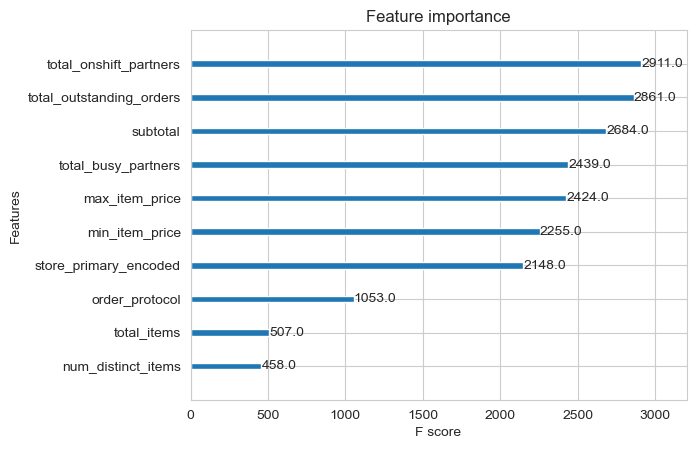

In [41]:
#1. XGB Classifier

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred),'\n')

# Plotting feature importances
plot_importance(xgb, max_num_features=10) # Cheeck Feature Importance
plt.show()

In [43]:
# 2. Light GBM

lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 139994, number of used features: 10
[LightGBM] [Info] Start training from score -4.312458
[LightGBM] [Info] Start training from score -0.977895
[LightGBM] [Info] Start training from score -0.873736
[LightGBM] [Info] Start training from score -1.644504
Accuracy:  0.5287293922683505


In [44]:
# 3. Random Forest

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.5073573530672305


In [45]:
# 4. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.4152690076859339


In [46]:
# 5. Gradient Boosting

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.4152690076859339


In [47]:
# 6. Logistic Regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print ('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.4152690076859339


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# 7. Ensemble - Hard Voting
warnings.filterwarnings('ignore')

clf_tree = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=19, random_state=42)
clf_bg = BaggingClassifier(DecisionTreeClassifier(max_depth=9,random_state=42),n_estimators=200,random_state=42)
clf_gb = GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1,random_state=42)
clf_xgb = XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.8, random_state=42)
clf_lgb = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.4, random_state=42)

clf_voting = VotingClassifier(estimators=[('tree', clf_tree),('rf', clf_rf),('bg', clf_bg),('gb', clf_gb),('xgb',clf_xgb),('lgb',clf_lgb)],n_jobs=-1, voting='hard')
clf_voting.fit(X_train2, y_train)

for clf in (clf_voting,):
    y_pred = clf.predict(X_test2)
    print('<' + clf.__class__.__name__ + '>')
    print('*Accuracy - {:.5f}\n'.format(accuracy_score(y_test, y_pred)))

<VotingClassifier>
*Accuracy - 0.52150



## Conclusion¶
We created a target variable 'How Long' and converted it into a categorical variable.

After running predictions on the classification models, we observed that the Light GBM Classifier yielded the highest accuracy among the models.

Following that, the XGB Classifier and Random Forest Classifier achieved around 50% accuracy, while other models notably exhibited lower accuracy.

Based on these results, we concluded that applying the Light GBM Classifier model to the Porter Delivery Time Estimation dataset is the most suitable choice.

Furthermore, comparing the results of predicting the 'How Long' variable using the first method as a continuous variable, we found that the performance was even better when treating it as a categorical variable.

This suggests that predicting with categorical values yields higher accuracy than predicting precise continuous values, thus confirming our hypothesis.